In [93]:
import pandas as pd 
import numpy as np
import faiss
import cv2

from skimage.feature import graycomatrix, graycoprops

import warnings
warnings.simplefilter("ignore")

### TEXTURE HISTOGRAMS

Read paths

In [94]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

Transformation function

In [95]:
def get_glcm_features(img, distances = [1, 3, 5, 7], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    
    # Calcular la GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
   
    # Extraer características: contraste, correlación, energía y homogeneidad
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
   
    # Combinar todas las características en un solo vector
    features = np.hstack([contrast, correlation, energy, homogeneity, asm, dissimilarity])
    return np.array([features], dtype=np.float32)

Application of the function

In [96]:
all_features = []
dimension = 96

for path in paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = get_glcm_features(img).reshape(dimension)
    all_features.append(features)

Creation of the index

In [97]:
index = faiss.IndexFlatL2(dimension)

vectores = np.array(all_features)

faiss.normalize_L2(vectores)

index.add(vectores)

In [98]:
faiss.write_index(index, "database\\texture_histograms.index")

Test

Distances:  [[0.         0.00060432 0.0011024  0.0012215  0.00132134]]
Indices:  [[  0 194  14 290 354]]


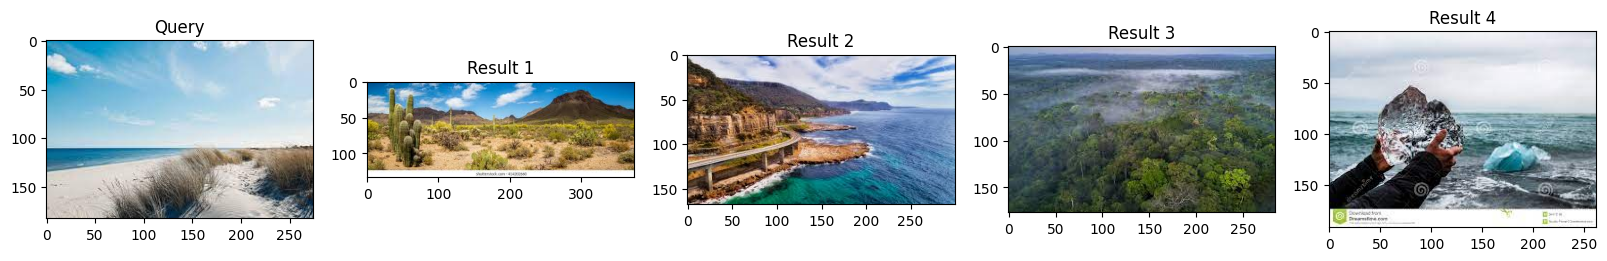

In [101]:
index = faiss.read_index("database\\texture_histograms.index")

img_test = "images\Training Data\Coast\Coast-Train (1).jpeg"

img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

query = get_glcm_features(img).reshape(dimension)

query = np.array([query])

faiss.normalize_L2(query)

k = 5
distances, indices = index.search(query, k)

print("Distances: ", distances)
print("Indices: ", indices)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title("Query")

for i in range(1, k):
    img = cv2.imread(paths[indices[0][i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Result " + str(i))

plt.show()